In [49]:
#Code used to train your own model, you need to structure your data in the same way as the data in the example_dataset folder

In [50]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from joblib import load

scaler = load('utils/df_scaler.bin')

while True:
    print('Pick a metric for training: Fractal dimension (1), Basin entropy (2), Boundary basin entropy (3), or Wada property (4).')
    _value1 = int(input())
    if _value1 == 1:
        metric_return = 'FDim'
        break
    elif _value1 == 2:
        metric_return = 'Sb'
        break
    elif _value1 == 3:
        metric_return = 'Sbb'
        break
    elif _value1 == 4:
        metric_return = 'Wada'
        break
    else:
        print('Please, choose between options 1, 2, 3, or 4.')

train_df = []
val_df = []
test_df = []

DuffingPath = r'example_dataset\Duffing\Duffing.csv'
Duffing_df = pd.read_csv(DuffingPath)
train_df.append(Duffing_df)

HHPath = r'example_dataset\Henon_Heiles\Henon_Heiles.csv'
HH_df = pd.read_csv(HHPath)
val_df.append(HH_df)

NewtonPath = r'example_dataset\Newton_fractal\Newton_fractal.csv'
Newton_df = pd.read_csv(NewtonPath)
train_df.append(Newton_df)

PAFPath = r'example_dataset\Forced_damped_pendulum\Forced_damped_pendulum.csv'
PAF_df = pd.read_csv(PAFPath)
val_df.append(PAF_df)

MagneticPendulumPath = r'example_dataset\Magnetic_pendulum\Magnetic_pendulum.csv'
MagneticPendulum_df = pd.read_csv(MagneticPendulumPath)
test_df.append(MagneticPendulum_df)

train_df = pd.concat(train_df).sample(frac=1).reset_index(drop=True)
val_df = pd.concat(val_df).sample(frac=1).reset_index(drop=True)
test_df = pd.concat(test_df).sample(frac=1).reset_index(drop=True)

train_df[['FDim','Sb','Sbb','Wada']] = scaler.fit_transform(train_df[['FDim','Sb','Sbb','Wada']])
val_df[['FDim','Sb','Sbb','Wada']] = scaler.fit_transform(val_df[['FDim','Sb','Sbb','Wada']])
test_df[['FDim','Sb','Sbb','Wada']] = scaler.fit_transform(test_df[['FDim','Sb','Sbb','Wada']])

print("There are", len(train_df), "basins for training which makes", len(train_df)/(len(train_df)+len(val_df)+len(test_df)), "of the total")
print("There are", len(val_df), "basins for validation which makes", len(val_df)/(len(train_df)+len(val_df)+len(test_df)), "of the total")
print("There are", len(test_df), "basins for testing which makes", len(test_df)/(len(train_df)+len(val_df)+len(test_df)), "of the total")

Pick a metric for training: Fractal dimension (1), Basin entropy (2), Boundary basin entropy (3), or Wada property (4).
There are 6 basins for training which makes 0.4 of the total
There are 6 basins for validation which makes 0.4 of the total
There are 3 basins for testing which makes 0.2 of the total


In [51]:
from utils.Image_Generator import custom_generator

batch_size = 16
    
train_set= custom_generator(train_df, batch_size, Apply_DataAug = True, metric_return = metric_return)
valid_set = custom_generator(val_df, batch_size, Apply_DataAug = True, metric_return = metric_return)
train_steps = len(train_df) // batch_size 
valid_steps = len(val_df) // batch_size

In [52]:
#----------------------------------------- Architecture and training of the CNN -----------------------------------------------------------
# The architectures of the CNNs are defined on Architecture.py

import utils.Architecture as Architecture
from keras.optimizers import Adam, SGD
from keras.callbacks import TensorBoard, TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from time import time
import os

sv_chk_path = 'results/checkpoints/'
sv_path = 'results/'
file_name = 'ResNet50_' + metric_return

optimizer = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True)

if metric_return != 'Wada':
    model = Architecture.ResNet50.ResNet50(input_shape=(333, 333, 1),outputs=1, activation='linear') 
    model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

    model_checkpoint = ModelCheckpoint(sv_chk_path+file_name+'_model.keras', monitor='val_mse', verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau('val_mse', factor=0.999, patience=int(10), cooldown=0, min_lr=1e-6, verbose=1)
    early_stop = EarlyStopping('val_mse', patience=30, verbose=1)
else: 
    model = Architecture.ResNet50.ResNet50(input_shape=(333, 333, 1),outputs=2, activation='softmax') 
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    model_checkpoint = ModelCheckpoint(sv_chk_path+file_name+'model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
    reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.999, patience=int(10), cooldown=0, min_lr=1e-6, verbose=1)
    early_stop = EarlyStopping('val_accuracy', patience=30, verbose=1)
    
terminate = TerminateOnNaN()
tensorboard = TensorBoard(log_dir=sv_path+'logs/'+file_name.format(time()), histogram_freq=1, write_graph=True, write_images=True)
callbacks = [model_checkpoint, early_stop, terminate, tensorboard, reduce_lr]

#model.summary()

In [53]:
# Fit the model
epochs = 100

history = model.fit(train_set,
                    epochs = epochs, 
                    batch_size = batch_size,
                    steps_per_epoch = train_steps,
                    validation_data= valid_set,
                    validation_steps = valid_steps,
                    callbacks=callbacks)    
model.save(sv_path+file_name+'modellast.h5')
np.save(sv_chk_path+file_name+'history1.npy',history.history)

"\nhistory = model.fit(train_set,\n                    epochs = epochs, \n                    batch_size = batch_size,\n                    steps_per_epoch = train_steps,\n                    validation_data= valid_set,\n                    validation_steps = valid_steps,\n                    callbacks=callbacks)    \nmodel.save(sv_path+file_name+'modellast.h5')\nnp.save(sv_chk_path+file_name+'history1.npy',history.history)\n"

In [ ]:
#model.load_weights('models/'+file_name+'_model.hdf5')

In [55]:
import pandas as pd
import numpy as np
import scipy.io as sp
from utils import Architecture
from utils.Image_Generator import Image_Loader
from tensorflow.keras.optimizers import Adam
from joblib import load
import warnings
warnings.filterwarnings("ignore")

# Load scaler
scaler = load('utils/df_scaler.bin') #NO QUITAR

# Shuffle and concatenate dataframes
test_df = test_df.sample(frac=1).reset_index(drop=True)

Basins_df = []; Basins_df.append(Duffing_df); Basins_df.append(HH_df); Basins_df.append(Newton_df); Basins_df.append(PAF_df); Basins_df.append(MagneticPendulum_df)
Basins_df = pd.concat(Basins_df).reset_index(drop=True)

# Load image data
test_image_set, FDim_label, Sb_label, Sbb_label, Wada_label = Image_Loader(Basins_df, 0, int(len(Basins_df)))

# Initialize Basins_Characterized_df
Basins_Characterized_df = pd.DataFrame(columns=['Name', 'FDim', 'Sb', 'Sbb', 'Wada'])
Basins_Characterized_df['Name'] = Basins_df['Name']; Basins_Characterized_df['FDim'] = 0; Basins_Characterized_df['Sb'] = 0; Basins_Characterized_df['Sbb'] = 0; Basins_Characterized_df['Wada'] = 0

# We need to flatten them to 1D arrays
if metric_return != 'Wada':     
    Basins_Characterized_df[metric_return] = model.predict(test_image_set).flatten()
else:
    Basins_Characterized_df['Wada'] = model.predict(test_image_set).argmax(axis=1)

# Inverse transform using the scaler
Basins_Characterized_df[['FDim', 'Sb', 'Sbb', 'Wada']] = scaler.inverse_transform(Basins_Characterized_df[['FDim', 'Sb', 'Sbb', 'Wada']])

# Map Wada values to labels
Basins_Characterized_df['Wada'] = Basins_Characterized_df['Wada'].map({0: 'No Wada', 1: 'Wada'})

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


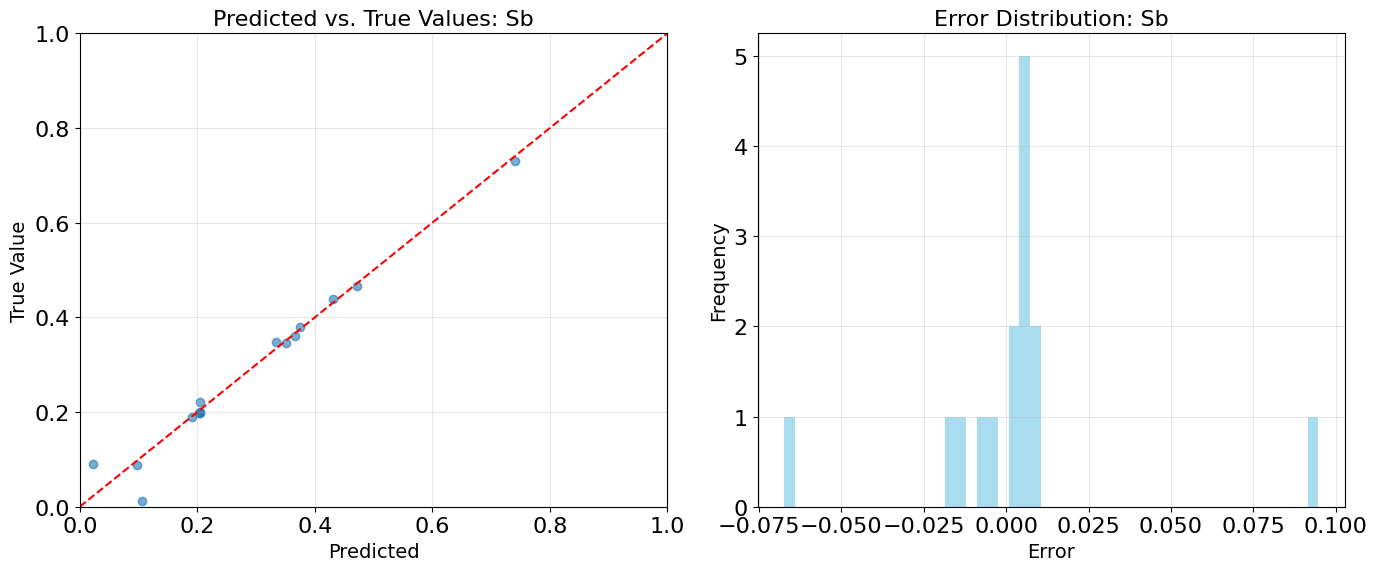

          Name  True Value  Predicted Value     Error
0   Duff_a.mat    0.346974         0.333784 -0.013190
1   Duff_b.mat    0.222107         0.204137 -0.017970
2   Duff_c.mat    0.199029         0.203847  0.004819
3     HH_a.mat    0.346220         0.350452  0.004232
4     HH_b.mat    0.199516         0.205073  0.005557
5     HH_c.mat    0.189024         0.190780  0.001756
6     Nf_a.mat    0.198810         0.202071  0.003261
7     Nf_b.mat    0.089607         0.022275 -0.067332
8     Nf_c.mat    0.011034         0.105808  0.094773
9     Fp_a.mat    0.438812         0.431653 -0.007159
10    Fp_b.mat    0.379797         0.374243 -0.005554
11    Fp_c.mat    0.087887         0.098057  0.010170
12    Mp_a.mat    0.731126         0.740679  0.009553
13    Mp_b.mat    0.360314         0.365851  0.005537
14    Mp_c.mat    0.465452         0.471313  0.005861


In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

if metric_return != 'Wada':
    # Map metric names to column indices
    metric_indices = {'FDim': 0, 'Sb': 1, 'Sbb': 2}
    metric_index = metric_indices[metric_return]
    
    # Get the scaled true labels
    if metric_return == 'FDim':
        true_values = FDim_label
    elif metric_return == 'Sb':
        true_values = Sb_label
    elif metric_return == 'Sbb':
        true_values = Sbb_label
    
    predicted_values = Basins_Characterized_df[metric_return].values
    
    # Calculate prediction errors
    errors = predicted_values - true_values
    
    # Plot Predicted vs. True Values
    plt.figure(figsize=(14, 6))
    
    # Scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(predicted_values, true_values, alpha=0.6)
    plt.title(f'Predicted vs. True Values: {metric_return}', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True Value', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Plot diagonal line for reference
    if metric_return == 'FDim':
        plt.xlim([1, 2])
        plt.ylim([1, 2])
        plt.plot([1, 2], [1, 2], 'r--')
    else:
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.plot([0, 1], [0, 1], 'r--')
    
    # Histogram of errors
    plt.subplot(1, 2, 2)
    plt.hist(errors, bins=50, alpha=0.7, color='skyblue')
    plt.title(f'Error Distribution: {metric_return}', fontsize=16)
    plt.xlabel('Error', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Create a DataFrame with results and errors
    result_df = pd.DataFrame({
        'Name': Basins_Characterized_df['Name'],
        'True Value': true_values,
        'Predicted Value': predicted_values,
        'Error': errors
    })
    
    # Display the results
    print(result_df[['Name', 'True Value', 'Predicted Value', 'Error']])
else:
    # For 'Wada' metric (classification problem)
    # Assuming Wada_label is one-hot encoded
    true_classes = np.argmax(Wada_label, axis=1)
    predicted_probs = model.predict(test_image_set)
    predicted_classes = np.argmax(predicted_probs, axis=1)
    
    # Compute the confusion matrix
    confusion_mat = confusion_matrix(true_classes, predicted_classes)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    ax = plt.subplot()
    sns.heatmap(
        confusion_mat / np.sum(confusion_mat),
        annot=True,
        fmt='.2%',
        cmap='Blues',
        xticklabels=['No Wada', 'Wada'],
        yticklabels=['No Wada', 'Wada']
    )
    
    plt.rcParams.update({'font.size': 16})
    ax.set_xlabel('Predicted Labels', fontsize=14)
    ax.set_ylabel('True Labels', fontsize=14)
    ax.set_title('Confusion Matrix', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=12)
    
    plt.show()
    
    # Optionally, display classification report
    from sklearn.metrics import classification_report
    print(classification_report(true_classes, predicted_classes, target_names=['No Wada', 'Wada']))
    
    # Create a DataFrame with results
    result_df = pd.DataFrame({
        'Name': Basins_Characterized_df['Name'],
        'True Class': true_classes,
        'Predicted Class': predicted_classes
    })
